<a href="https://colab.research.google.com/github/madhugrover/Thinkful_projects/blob/master/tesla_org.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install keras

In [0]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np 
from matplotlib import style

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
# Get the stock data using yahoo API:
style.use('ggplot')

# get 2014-2019 data to train our model
start = datetime.datetime(2014,1,1)
end = datetime.datetime(2019,12,31)
df = web.DataReader("TSLA", 'yahoo', start, end) 

# get 2019 data to test our model on 
start = datetime.datetime(2020,1,1)
end = datetime.date.today()
test_df = web.DataReader("TSLA", 'yahoo', start, end) 

In [0]:
test_df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-16,494.869995,442.170013,469.500000,445.070007,20489500,445.070007
2020-03-17,471.850006,396.000000,440.010010,430.200012,23994600,430.200012
2020-03-18,404.859985,350.510010,389.000000,361.220001,23786200,361.220001
2020-03-19,452.000000,358.459991,374.700012,427.640015,30195500,427.640015
2020-03-20,477.000000,425.790009,438.200012,427.529999,28247200,427.529999


In [0]:
# sort by date
df = df.sort_values('Date')
test_df = test_df.sort_values('Date')

In [0]:
# fix the date 
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)
test_df.reset_index(inplace=True)
test_df.set_index("Date", inplace=True)

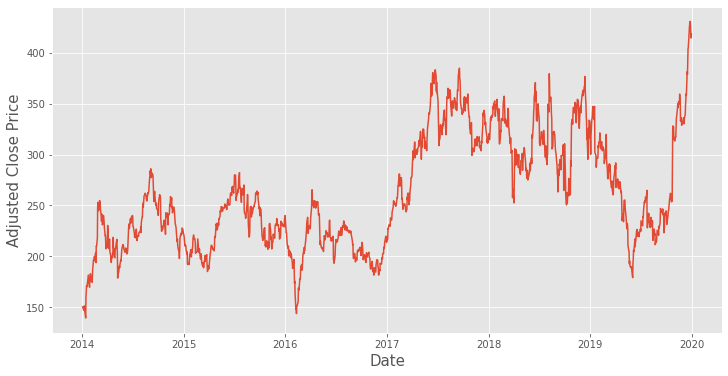

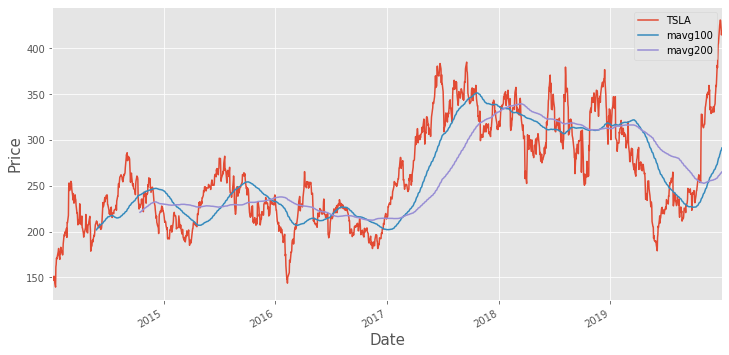

In [0]:
# Visualize the training stock data:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(df["Adj Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Adjusted Close Price',fontsize=15)
plt.show()


# Rolling mean
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
mavg2 = close_px.rolling(window=200).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='TSLA')
mavg.plot(label='mavg100')
mavg2.plot(label='mavg200')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.legend();

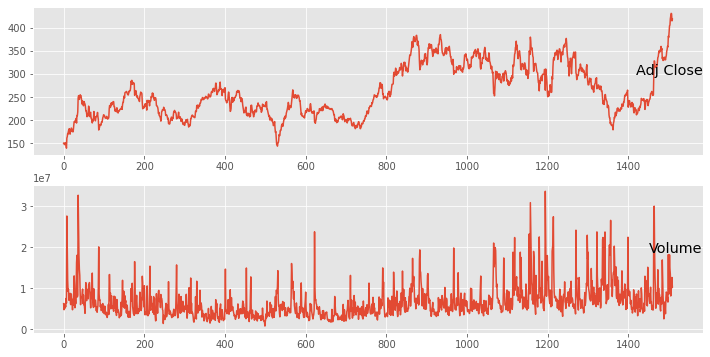

In [0]:
from matplotlib import pyplot
values = df.values
# specify columns to plot
groups = [5, 4]
i = 1
# plot each column
pyplot.figure(figsize = (12,6))
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [0]:
import matplotlib.dates as mdates

# change the dates into ints for training 
dates_df = df.copy()
dates_df = dates_df.reset_index()

# Store the original dates for plotting the predicitons
org_dates = dates_df['Date']

# convert to ints
dates_df['Date'] = dates_df['Date'].map(mdates.date2num)

dates_df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
1505,737417.0,425.470001,412.690002,418.359985,425.250000,8054700,425.250000
1506,737419.0,433.480011,426.350006,427.910004,430.940002,10633900,430.940002
1507,737420.0,435.309998,426.109985,435.000000,430.380005,9945700,430.380005
1508,737423.0,429.000000,409.260010,428.790009,414.700012,12586400,414.700012
1509,737424.0,421.290009,402.079987,405.000000,418.329987,10285700,418.329987


In [0]:
# Create train set of adj close prices data:
train_data = df.loc[:,'Adj Close'].as_matrix()
print(train_data.shape) # 1258 

(1510,)


In [0]:
# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)
print(train_data.shape)

(1510, 1)


In [0]:
# Function to create a dataset to feed into an LSTM
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [0]:
# Create the data to train our model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)

(1474, 36, 1)


In [0]:
# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

X_train:
[[150.1000061 ]
 [149.55999756]
 [147.        ]
 [149.36000061]
 [151.27999878]
 [147.52999878]
 [145.72000122]
 [139.33999634]
 [161.27000427]
 [164.13000488]
 [170.97000122]
 [170.00999451]
 [176.67999268]
 [178.55999756]
 [181.5       ]
 [174.6000061 ]
 [169.61999512]
 [178.38000488]
 [175.22999573]
 [182.83999634]
 [181.41000366]
 [177.11000061]
 [178.72999573]
 [174.41999817]
 [178.38000488]
 [186.52999878]
 [196.55999756]
 [196.61999512]
 [195.32000732]
 [199.63000488]
 [198.22999573]
 [203.69999695]
 [193.63999939]
 [209.97000122]
 [209.6000061 ]
 [217.6499939 ]]


y_train: [[248.]]



In [0]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 19, batch_size = 10, validation_split=.30)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1031 samples, validate on 443 samples
Epoch 1/19





1031/1031 [==============================] - 9s 8ms/step - loss: 0.0099 - val_loss: 0.0049
Epoch 2/19
1031/1031 [==============================] - 7s 7ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 3/19
1031/1031 [==============================] - 7s 6ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 4/19
1031/1031 [==============================] - 7s 7ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 5/19
1031/1031 [==============================] - 7s 7ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 6/19
1031/1031 [==============================] - 7s 7ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 7/19
1031/1031 [==============================] - 7s 7ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 8/19
1031/1

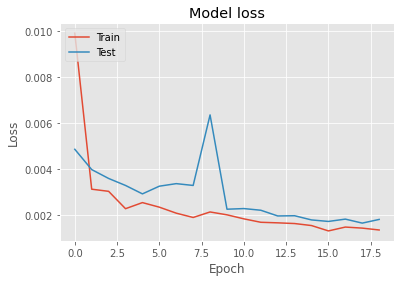

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

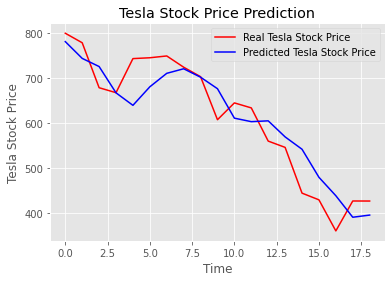

In [0]:
# Get the stock prices for 2020 to have our model make the predictions
test_data = test_df['Adj Close'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)


# plot the results 
plt.plot(org_y, color = 'red', label = 'Real Tesla Stock Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

In [0]:
org_y = list(org_y)
data = pd.DataFrame(org_y,columns =['data'])
data.reset_index(inplace=True)
predicted_y = list(predicted_y)
prediction = pd.DataFrame(predicted_y,columns=['prediction'])
prediction.reset_index(inplace=True)

In [0]:
result = pd.merge(data, prediction, on='index')
error = result['prediction'] - result['data']
result['error'] =error
result

,index,data,prediction,error
0,0,799.909973,781.316040,-18.593933
1,1,778.799988,744.096497,-34.703491
2,2,679.000000,726.029175,47.029175
3,3,667.989990,667.626770,-0.363220
4,4,743.619995,639.941101,-103.678894
5,5,745.510010,681.046997,-64.463013
6,6,749.500000,710.948730,-38.551270
7,7,724.539978,721.064453,-3.475525
8,8,703.479980,702.382080,-1.097900
9,9,608.000000,676.826111,68.826111


In [0]:
import pickle
pickle_out = pickle.dump(model, open("model_tesla", "wb"))

In [0]:
model = pickle.load(open("model_tesla", 'rb'))

NameError: ignored

In [0]:
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [test_data[0,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
        
    preds_moving = scaler.inverse_transform(preds_moving)
    
    return preds_moving

In [0]:
preds_moving = moving_test_window_preds(10)

NameError: ignored

In [0]:
pyplot.plot(actuals)
pyplot.plot(preds_moving)
pyplot.show()